# Modules and global variables

In [1]:
%matplotlib inline

import argparse
from collections import defaultdict, OrderedDict
import multiprocessing as mp
import os
import pickle
import re
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
root_data_dir = subprocess.check_output(
    "echo $MB_PROCESSED/vcf_to_ase/", 
    shell=True
).decode("UTF-8").strip()
sample_data_dir = "/".join([root_data_dir, "first_sample", "scRNA"])

cluster_label_col = "cl_hierarchical"#"seurat_clusters"
barcode_col = "barcode"

In [3]:
scDNA_dir = f"{root_data_dir}/first_sample/scDNA"
scRNA_dir = f"{root_data_dir}/first_sample/scRNA"

# Utilities

In [4]:
def extract_barcodes(df):
    barcode_list = []
    barcode_pattern = r"(^(A|C|G|T)+-1)|(.*_(ad|dp)$)"
    for colname in df.columns:
        if re.match(barcode_pattern, colname) is not None:
            barcode_list.append(colname.split("_")[0])
    return np.unique(barcode_list)


def extract_snps(df):
    return np.array([
        f"{chrom},{pos}"
        for chrom, pos in 
        tqdm_notebook(df[["CHROM", "POS"]]\
                      .to_dense()\
                      .values\
                      .astype(np.int64), 
                      desc="extracting snps...")
    ])


def extract_counts(df, suffix="dp"):
    barcode_list = extract_barcodes(df)
    return df[[f"{barcode}_{suffix}" for barcode in barcode_list]]

In [5]:
def extract_clusters(clustering_df, entry_col="BARCODE"):
    cluster_to_entries = {}
    for label, indices in clustering_df.groupby("LABEL").groups.items():
        cluster_to_entries[label] = clustering_df[entry_col][indices].values
    return cluster_to_entries


def extract_cluster_labels(clustering_df):
    return sorted(clustering_df.LABEL.unique())

# Classifier

In [6]:
def aggregate_by_barcode_groups(counts_df, clustering_df):
    assert np.all(np.isin(clustering_df.BARCODE, 
                          extract_barcodes(counts_df)))
    
    cluster_to_barcodes = extract_clusters(clustering_df)
    cluster_labels = extract_cluster_labels(clustering_df)
    
    result_df = pd.DataFrame()
    
    for label in tqdm_notebook(cluster_labels, desc="cluster label"):
        for suffix in ["ad", "dp"]:
            result_df[f"{label}_{suffix}"] = np.zeros(counts_df.shape[0])    
            na_mask = np.full(counts_df.shape[0], True)
            for barcode in cluster_to_barcodes[label]:
                counts = counts_df[f"{barcode}_{suffix}"].to_dense().values
                na_mask = na_mask & np.isnan(counts)
                result_df[f"{label}_{suffix}"] += np.nan_to_num(counts)
            result_df[f"{label}_{suffix}"][na_mask] = np.nan
    return result_df

In [7]:
def compute_ase(counts_df, barcode_list):
    ase_df = pd.concat([
        pd.DataFrame({
            f"{barcode}" 
            : counts_df[f"{barcode}_ad"].to_dense().fillna(0) 
            / counts_df[f"{barcode}_dp"].to_dense().fillna(0)
        }) 
        for barcode in tqdm_notebook(barcode_list, desc="barcode")], 
        axis=1
    )
    return ase_df

In [23]:
def plot_ase(ase_df, title="", figsize=(10,10), **clustermap_kwargs):
    try: 
        sns.clustermap(
            ase_df\
            .fillna(value=0.5)\
            .astype(np.float32)\
            .values,
            cmap="viridis",
            figsize=figsize,
            row_cluster=False,
            xticklabels=[colname for colname in ase_df.columns 
                         if colname != "GENE_ID"], 
            **clustermap_kwargs
        ).fig.suptitle(title);
    except RecursionError:
        print("RecursionError: increase stack size")

In [67]:
class ASEClassifier:
    def __init__(self, dna_clustering_df, rna_clustering_df):
        self.dna_clustering_df = dna_clustering_df
        self.rna_clustering_df = rna_clustering_df
        
    def _assign_label(self, barcode):
        loglikelihood = []
        for cluster_label in self.dna_ase_df.columns:
            if cluster_label == "GENE_ID": continue
                
            Nm = self.rna_counts_df[f"{barcode}_ad"]
            Np = self.rna_counts_df[f"{barcode}_dp"] - Nm
            profile = self.dna_ase_df[cluster_label].values
            
            loglikelihood.append(
                (((profile > 0) | (Nm == 0)) * Nm * np.log(profile)).dropna().values.sum()
                + (((profile < 1) | (Np == 0)) * Np * np.log(1 - profile)).dropna().values.sum()
            )
#         print(loglikelihood)
        return np.nanargmax(loglikelihood)
        
    def predict(self, scRNA_counts_df, scDNA_ase_df):
        # Different genes are expressed in the datasets,
        # so we need to find the intersection and drop out the rest
        self.rna_counts_df = scRNA_counts_df
        self.dna_ase_df = scDNA_ase_df
        
        self.labels = np.array(
            [
                self._assign_label(barcode) for barcode in 
                tqdm_notebook(extract_barcodes(self.rna_counts_df), 
                              desc="barcode processing")
            ]
        )

        return self.labels
    
    def classification_report(self, labels, title):
        sns.set()
        plt.figure(figsize=(20,10))
        plt.title("Cluster label assigned by MLE", fontsize=20)
        sns.countplot(labels)
        
        sns.set(font_scale=1.5);
        plt.figure(figsize=(20,10))
    
        plt.title(title)
        
        sns.scatterplot(
            x="TSNE_1", y="TSNE_2", 
            hue=labels, 
            data=self.rna_clustering_df, 
            palette="jet"
        );
        plt.legend().get_frame().set_facecolor("white");

# Runtime

In [68]:
scDNA_ase_df = pd.read_pickle(f"{scDNA_dir}/1kPC1_^_1kPC2_clustered_ase.pkl").to_dense().reset_index(drop=True)
scRNA_counts_df = pd.read_pickle(f"{scRNA_dir}/1kPC1_^_1kPC2_gene_counts.pkl").to_dense().reset_index(drop=True)

In [69]:
scRNA_ase_df = pd.read_pickle(f"{scRNA_dir}/1kPC1_^_1kPC2_clustered_ase.pkl").to_dense().reset_index(drop=True)
scDNA_counts_df = pd.read_pickle(f"{scDNA_dir}/1kPC1_^_1kPC2_gene_counts.pkl").to_dense().reset_index(drop=True)

In [70]:
len(np.intersect1d(scDNA_counts_df.GENE_ID, scRNA_counts_df.GENE_ID))

213

In [71]:
dna_clustering_df = pd.read_csv(f"{scDNA_dir}/clustering.csv")
dna_clustering_df.head()

,LABEL,BARCODE,TSNE_1,TSNE_2
0,1,AAACCTGTCTTGCGAA-1,9.411309,2.267972
1,1,AAACGGGAGTGTTGAA-1,4.764729,3.159622
2,3,AAACGGGGTACTCACA-1,-20.151240,6.528130
3,1,AAAGCAAAGCTGGTCC-1,9.120229,-3.189401
4,1,AAAGCAAAGGCCATAG-1,1.129511,-0.906303


In [72]:
rna_clustering_df = pd.read_csv(f"{scRNA_dir}/clustering.csv")
rna_clustering_df.head()

,BARCODE,LABEL,TSNE_1,TSNE_2
0,AAACCTGCACATCCAA-1,1,-12.448108,27.412456
1,AAACCTGCACTAGTAC-1,0,9.738823,11.845293
2,AAACCTGCATCATCCC-1,2,7.208576,-9.511222
3,AAACCTGGTAGCTCCG-1,1,-20.766361,18.106085
4,AAACCTGGTCTAAACC-1,2,5.619219,-12.530333


In [73]:
scDNA_ase_df["GENE_ID"] = scDNA_counts_df.GENE_ID
scDNA_ase_df.GENE_ID

0                        ENSG00000130413,ENSG00000252778
1                        ENSG00000254645,ENSG00000254695
2      ENSG00000124422,ENSG00000205212,ENSG0000022698...
3                                        ENSG00000109016
4        ENSG00000178307,ENSG00000235530,ENSG00000263815
                             ...                        
301                      ENSG00000107186,ENSG00000234740
302                                      ENSG00000226197
303                                      ENSG00000205636
304                                      ENSG00000235533
305      ENSG00000147862,ENSG00000225472,ENSG00000234982
Name: GENE_ID, Length: 306, dtype: object

In [74]:
scRNA_ase_df["GENE_ID"] = scRNA_counts_df.GENE_ID
scRNA_ase_df.GENE_ID

0                        ENSG00000130413,ENSG00000252778
1                        ENSG00000254645,ENSG00000254695
2      ENSG00000124422,ENSG00000205212,ENSG0000022698...
3                                        ENSG00000109016
4        ENSG00000178307,ENSG00000235530,ENSG00000263815
                             ...                        
208                                      ENSG00000229611
209                      ENSG00000107186,ENSG00000234740
210                                      ENSG00000226197
211                                      ENSG00000235533
212      ENSG00000147862,ENSG00000225472,ENSG00000234982
Name: GENE_ID, Length: 213, dtype: object

In [94]:
%%time
common_genes = set(scDNA_ase_df.GENE_ID) & set(scRNA_counts_df.GENE_ID)
scDNA_ase_df = scDNA_ase_df[scDNA_ase_df.GENE_ID.isin(common_genes)]
scRNA_ase_df = scRNA_ase_df[scRNA_ase_df.GENE_ID.isin(common_genes)]
scRNA_counts_df = scRNA_counts_df[scRNA_counts_df.GENE_ID.isin(common_genes)]
scDNA_counts_df = scDNA_counts_df[scDNA_counts_df.GENE_ID.isin(common_genes)]

CPU times: user 43.7 ms, sys: 38.2 ms, total: 81.9 ms
Wall time: 76.1 ms


In [77]:
# scRNA_ase_df.fillna(0.5, inplace=True)
# scDNA_ase_df.fillna(0.5, inplace=True)

In [78]:
scRNA_counts_df.GENE_ID

0                        ENSG00000130413,ENSG00000252778
1                        ENSG00000254645,ENSG00000254695
2      ENSG00000124422,ENSG00000205212,ENSG0000022698...
3                                        ENSG00000109016
4        ENSG00000178307,ENSG00000235530,ENSG00000263815
                             ...                        
208                                      ENSG00000229611
209                      ENSG00000107186,ENSG00000234740
210                                      ENSG00000226197
211                                      ENSG00000235533
212      ENSG00000147862,ENSG00000225472,ENSG00000234982
Name: GENE_ID, Length: 213, dtype: object

In [79]:
clustered_scRNA_counts_df = aggregate_by_barcode_groups(
    scRNA_counts_df,
    rna_clustering_df
)

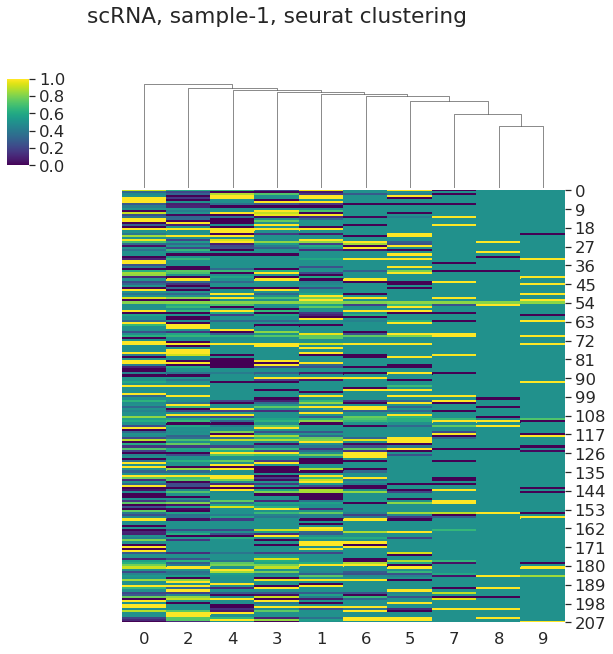

In [60]:
plot_ase(compute_ase(clustered_scRNA_counts_df, 
         extract_barcodes(clustered_scRNA_counts_df)),
         "scRNA, sample-1, seurat clustering")

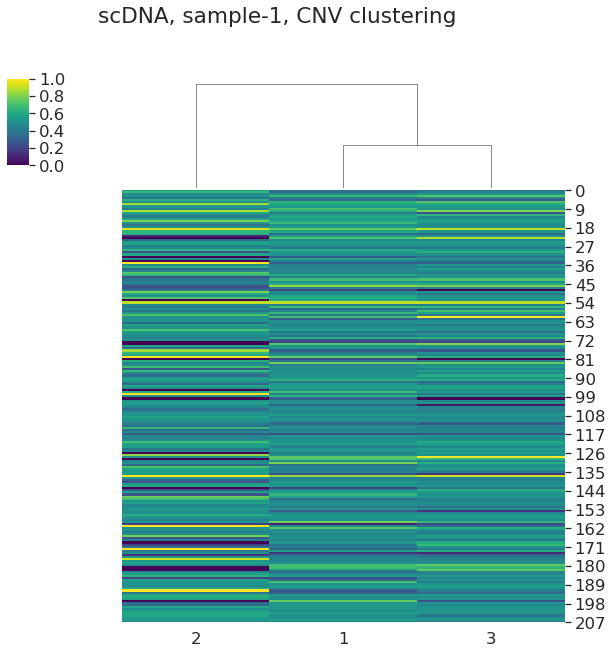

In [61]:
plot_ase(scDNA_ase_df.drop(columns=["GENE_ID"]),
         "scDNA, sample-1, CNV clustering")

/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


CPU times: user 390 ms, sys: 81.7 ms, total: 472 ms
Wall time: 379 ms


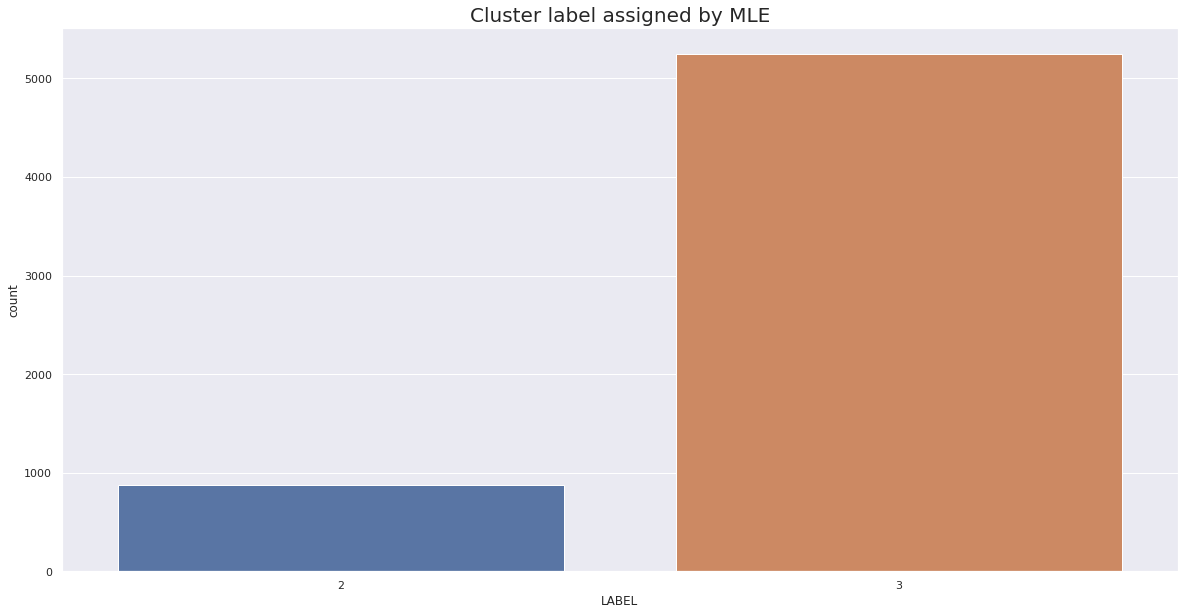

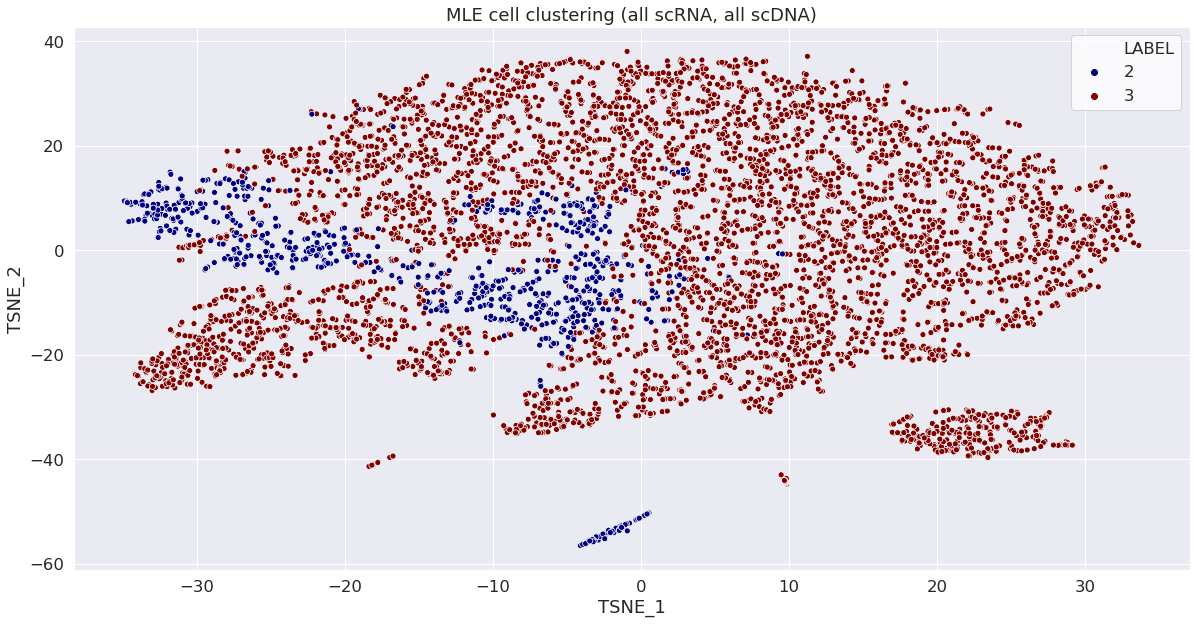

In [80]:
%%time
clf = ASEClassifier(dna_clustering_df, rna_clustering_df)
labels = clf.predict(clustered_scRNA_counts_df, scDNA_ase_df)
clf.classification_report(rna_clustering_df.LABEL.apply(lambda i: labels[i]+1), 
                          "MLE cell clustering (all scRNA, all scDNA)")